# Tabular Data using Energy Flow Polynomials

In this lab, we will treat jets as tabular data using energy flow polynomials (EFPs)

In [53]:
!pip install jetnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download dataset using JetNet library

Download top quarks and light quark datasets using JetNet library

In [62]:
import jetnet

data_t = jetnet.datasets.JetNet(jet_type='t')
data_t.download_and_convert_to_pt(data_dir='./', jet_type='t')

data_q = jetnet.datasets.JetNet(jet_type='q')
data_q.download_and_convert_to_pt(data_dir='./', jet_type='q')

In [93]:
import torch
n = 2000
data_t_pt = torch.load("t.pt")[:n]
data_q_pt = torch.load("q.pt")[:n]
X_jets_pt = torch.cat([data_t_pt, data_q_pt])
y_pt = torch.cat([torch.ones(n), torch.zeros(n)])
y_np = y_pt.numpy()

# Calculate Energy Flow Polynomials

In [99]:
X_efps_np = jetnet.utils.efps(X_jets_pt[:,:,:3].numpy(),  efpset_args=[("n==", 4), ("d==", 4), ("p==", 1)])

# Split data

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_efps_np, y_np, stratify=y_np, random_state=42, test_size=0.25
)

# Plot EFPs

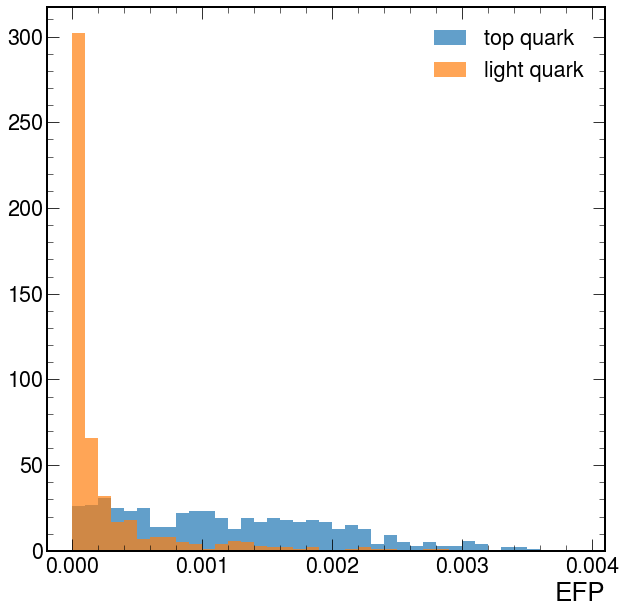

In [95]:
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
import numpy as np

plt.figure()
plt.hist(X_test[:,0], weights=y_test, bins=np.arange(0, 0.004, 0.0001), alpha=0.7, label="top quark")
plt.hist(X_test[:,0], weights=(1-y_test), bins=np.arange(0, 0.004, 0.0001), alpha=0.7, label="light quark")
plt.xlabel("EFP")
plt.legend()
plt.show()

# Train Boosted Decision Tree

In [55]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=3,
                        n_estimators=10,
                        n_jobs=-1)

clf.fit(X_train, y_train)

XGBClassifier(n_estimators=10, n_jobs=-1)

# Evaluate BDT Performance

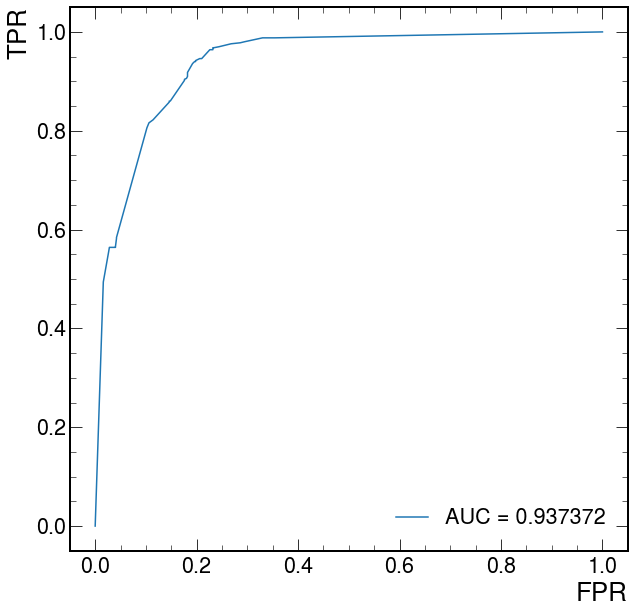

In [98]:
from sklearn.metrics import roc_curve, auc
y_xgb = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_xgb)
auc_t = auc(fpr, tpr)
  
plt.figure()
plt.plot(fpr, tpr, label='AUC = {}'.format(auc_t))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()